In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import callbacks as cb
import os, json, math, librosa
import IPython.display as ipd
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split

In [ ]:
file = "/content/drive/MyDrive/GTZAN dataset/genres_original/classical/classical.00010.wav"
print(file)

/content/drive/MyDrive/GTZAN dataset/genres_original/classical/classical.00010.wav


/content/drive/MyDrive/GTZAN dataset/genres_original/classical/classical.00010.wav


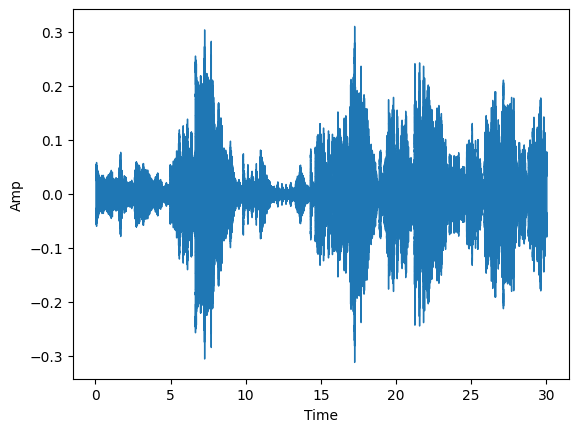

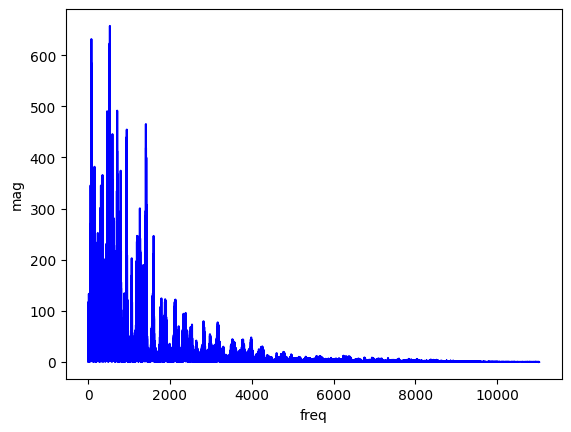

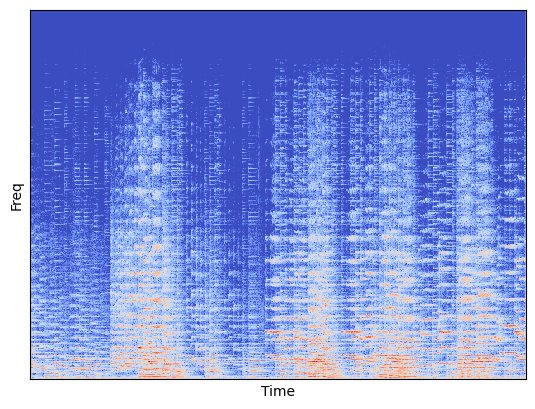

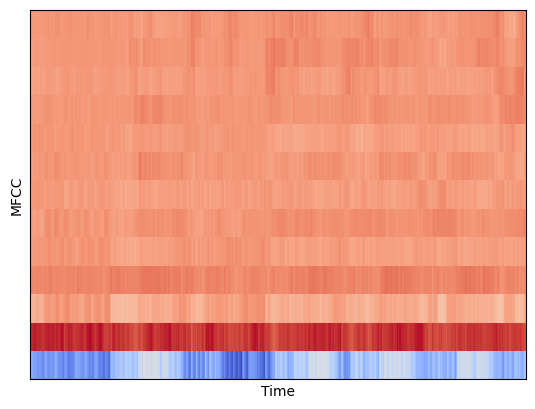

In [ ]:
file = "/content/drive/MyDrive/GTZAN dataset/genres_original/classical/classical.00010.wav"
print(file)


# waveform
signal, sr = librosa.load(file, sr=22050)
dis.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()


# fft -> spectrum
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_freq = frequency[: int(len(frequency) / 2)]
left_mag = magnitude[: int(len(magnitude) / 2)]

plt.plot(left_freq, left_mag, color="b")
plt.xlabel("freq")
plt.ylabel("mag")
plt.show()


# fft
n_fft = 2048  # window when considering performing a single fft
hop_length = 512  # amount shifting after each transform

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.show()


# mfcc
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.show()

In [ ]:
# Getting Genres from folder name

MUSIC = '../content/drive/MyDrive/GTZAN dataset/genres_original'
music_dataset = [] # File locations for each wav file
genre_target = [] #
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/content/drive/MyDrive/GTZAN dataset/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[5])

In [ ]:
print("genres in dataset: ", set(genre_target))

genres in dataset:  {'genres_original'}


In [ ]:
audio_path = music_dataset[500]

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

In [ ]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
# librosa.display.waveplot(x, sr=sr)

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

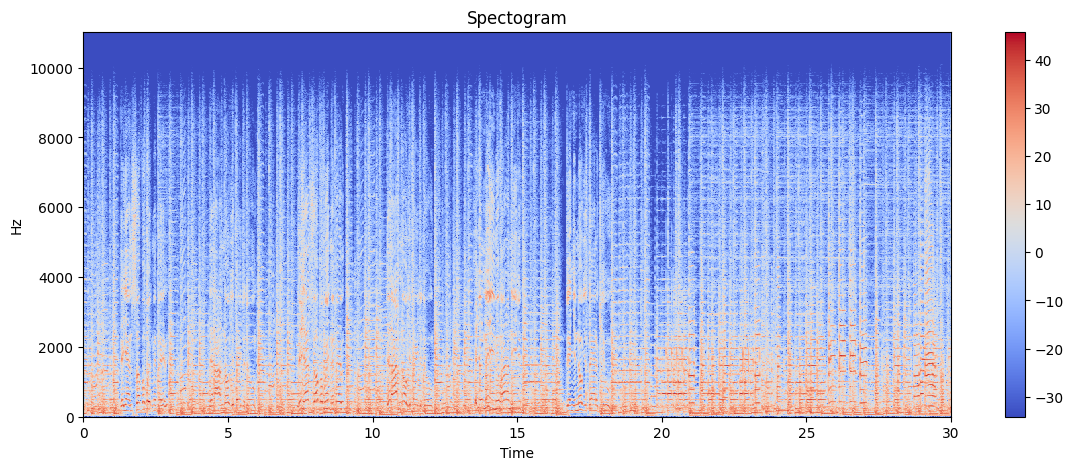

In [ ]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

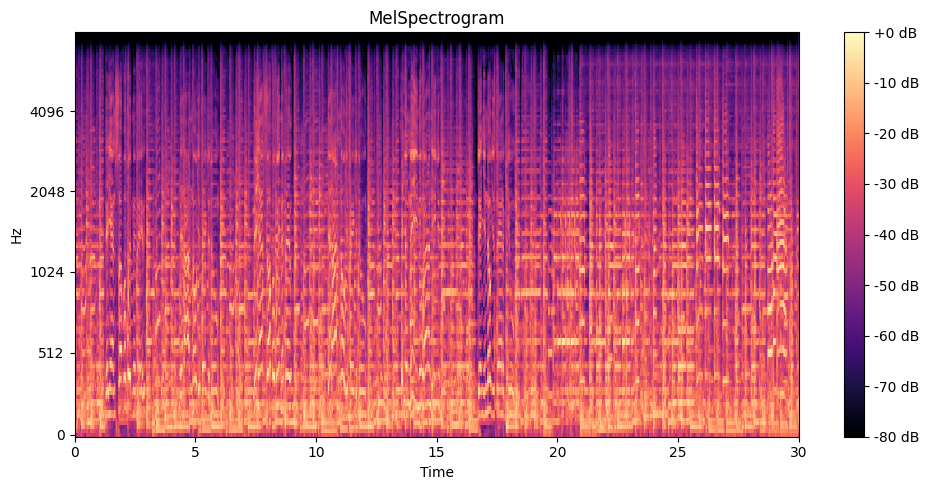

In [ ]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


In [ ]:
DATASET_PATH = '../content/drive/MyDrive/GTZAN dataset/genres_original'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                if file_path != '../content/drive/MyDrive/GTZAN dataset/genres_original/jazz/jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=15)
print("process finished")


Processing: hiphop

Processing: disco

Processing: metal

Processing: jazz

Processing: pop

Processing: blues

Processing: reggae

Processing: country

Processing: classical

Processing: rock
process finished


In [ ]:
DATA_PATH = "./data_10.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    X, y, z = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True,random_state =42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1, shuffle = True, random_state = 42)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0)

# create network
input_shape = (X_train.shape[1])
X_train.shape


(13477, 87, 13, 1)

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential,Model
def inceptionnet(x,filters):

    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)

    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)


    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)

    #(5x5) layer

    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)

    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)



    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)


    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])


def helperfunction(x,name=None):

    layer=AveragePooling2D(pool_size=(5,5),strides=3,padding="valid")(x)

    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)

    layer=Flatten()(layer)

    layer=Dense(units=255,activation="relu")(layer)

    layer=Dropout(0.4)(layer)
    layer=Dense(units=38,activation="softmax",name=name)(layer)

    return layer


def googlenet():

    #taking layer input
    inputlayer=Input(shape=(120,120,3))

    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)

    layer=BatchNormalization()(layer)

    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)

    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)

    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)

    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)

    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")

    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")

    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)


    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)

    #layer_6

    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=38,activation="softmax",name="final_layer_2")(layer)


    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])

    return model

In [ ]:
model=googlenet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 60, 60, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
import torchvision.models as models
googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:03<00:00, 13.9MB/s]


In [ ]:
def build_model(input_shape):
#      input_shape=(-1, 87, 13, 1)
    model = Sequential()
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape = input_shape),
    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

    return model

input_shape = (X_train.shape[1],X_train.shape[2],1)
model1 = build_model(input_shape)

In [ ]:
DATA_PATH = "./data_10.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    X, y, z = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True,random_state =42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1, shuffle = True, random_state = 42)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
#      input_shape=(-1, 87, 13, 1)
    model = Sequential()
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape = input_shape),
    keras.layers.BatchNormalization(),
#    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

    return model


def predict(model, X, y):

    X = X[np.newaxis, ...]
    print("heo",X.shape)
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [ ]:
# os.mkdir('callbacks')
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0)
# X_train = np.reshape(X_train,(-1,87,13,1))
# print(X_train.shape)

In [ ]:
# get train, validation, test splits
print(X_train.shape)
# create network
input_shape = (X_train.shape[1],X_train.shape[2],1)
model = build_model(input_shape)

# # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0025)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath = "/kaggle/working/callbacks",
    monitor = "val_loss",
    mode = "min"
)]
model.summary()

(13477, 87, 13, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 20, 1, 96)         11712     
                                                                 
 batch_normalization_7 (Batc  (None, 20, 1, 96)        384       
 hNormalization)                                                 
                                                                 
 conv2d_65 (Conv2D)          (None, 20, 1, 256)        614656    
                                                                 
 batch_normalization_8 (Batc  (None, 20, 1, 256)       1024      
 hNormalization)                                                 
                                                                 
 conv2d_66 (Conv2D)          (None, 20, 1, 384)        885120    
                                                                 
 batch_normalization_9 (Batc  (None

In [ ]:

import os
import time
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 8.2374 - accuracy: 0.2692 

27/27 [==============================] - 335s 12s/step - loss: 8.2374 - accuracy: 0.2692 - val_loss: 199.6738 - val_accuracy: 0.0968
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.9443 - accuracy: 0.4088 

27/27 [==============================] - 337s 12s/step - loss: 1.9443 - accuracy: 0.4088 - val_loss: 32.1506 - val_accuracy: 0.0888
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.5533 - accuracy: 0.4528 

27/27 [==============================] - 337s 12s/step - loss: 1.5533 - accuracy: 0.4528 - val_loss: 8.9239 - val_accuracy: 0.1081
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 1.4136 - accuracy: 0.4879 

27/27 [==============================] - 349s 13s/step - loss: 1.4136 - accuracy: 0.4879 - val_loss: 2.1762 - val_accuracy: 0.2457
Epoch 5/20
27/27 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.5251 

27/27 [==============================] - 341s 13s/step - loss: 1.3356 - accuracy: 0.5251 - val_loss: 2.1826 - val_accuracy: 0.3485
Epoch 6/20
27/27 [==============================] - ETA: 0s - loss: 1.2683 - accuracy: 0.5449 

27/27 [==============================] - 346s 13s/step - loss: 1.2683 - accuracy: 0.5449 - val_loss: 2.0126 - val_accuracy: 0.4079
Epoch 7/20
27/27 [==============================] - ETA: 0s - loss: 1.2605 - accuracy: 0.5633 

27/27 [==============================] - 342s 13s/step - loss: 1.2605 - accuracy: 0.5633 - val_loss: 1.5923 - val_accuracy: 0.5000
Epoch 8/20
27/27 [==============================] - ETA: 0s - loss: 1.2143 - accuracy: 0.5754 

27/27 [==============================] - 342s 13s/step - loss: 1.2143 - accuracy: 0.5754 - val_loss: 1.4517 - val_accuracy: 0.5073
Epoch 9/20
27/27 [==============================] - ETA: 0s - loss: 1.1192 - accuracy: 0.6122 

27/27 [==============================] - 344s 13s/step - loss: 1.1192 - accuracy: 0.6122 - val_loss: 1.5515 - val_accuracy: 0.5320
Epoch 10/20
27/27 [==============================] - ETA: 0s - loss: 1.1302 - accuracy: 0.6156 

27/27 [==============================] - 336s 12s/step - loss: 1.1302 - accuracy: 0.6156 - val_loss: 1.4142 - val_accuracy: 0.5861
Epoch 11/20
27/27 [==============================] - ETA: 0s - loss: 1.1222 - accuracy: 0.6224 

27/27 [==============================] - 347s 13s/step - loss: 1.1222 - accuracy: 0.6224 - val_loss: 1.6101 - val_accuracy: 0.4973
Epoch 12/20
27/27 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.6486 

27/27 [==============================] - 346s 13s/step - loss: 1.0396 - accuracy: 0.6486 - val_loss: 1.1737 - val_accuracy: 0.6015
Epoch 13/20
27/27 [==============================] - ETA: 0s - loss: 1.0189 - accuracy: 0.6513 

27/27 [==============================] - 341s 13s/step - loss: 1.0189 - accuracy: 0.6513 - val_loss: 1.3030 - val_accuracy: 0.5941
Epoch 14/20
27/27 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.6628 

27/27 [==============================] - 333s 12s/step - loss: 0.9922 - accuracy: 0.6628 - val_loss: 1.0498 - val_accuracy: 0.6422
Epoch 15/20
27/27 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.6755 

27/27 [==============================] - 338s 13s/step - loss: 0.9695 - accuracy: 0.6755 - val_loss: 1.0601 - val_accuracy: 0.6308
Epoch 16/20
27/27 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.6883 

27/27 [==============================] - 334s 12s/step - loss: 0.9634 - accuracy: 0.6883 - val_loss: 1.2373 - val_accuracy: 0.6135
Epoch 17/20
27/27 [==============================] - ETA: 0s - loss: 0.9180 - accuracy: 0.6892 

27/27 [==============================] - 342s 13s/step - loss: 0.9180 - accuracy: 0.6892 - val_loss: 1.0832 - val_accuracy: 0.6502
Epoch 18/20
27/27 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.7075 

27/27 [==============================] - 337s 12s/step - loss: 0.8814 - accuracy: 0.7075 - val_loss: 1.1145 - val_accuracy: 0.6449
Epoch 19/20
27/27 [==============================] - ETA: 0s - loss: 0.8649 - accuracy: 0.7177 

27/27 [==============================] - 337s 13s/step - loss: 0.8649 - accuracy: 0.7177 - val_loss: 1.2187 - val_accuracy: 0.6429
Epoch 20/20
27/27 [==============================] - ETA: 0s - loss: 0.8710 - accuracy: 0.7209 

27/27 [==============================] - 342s 12s/step - loss: 0.8710 - accuracy: 0.7209 - val_loss: 1.0626 - val_accuracy: 0.6749


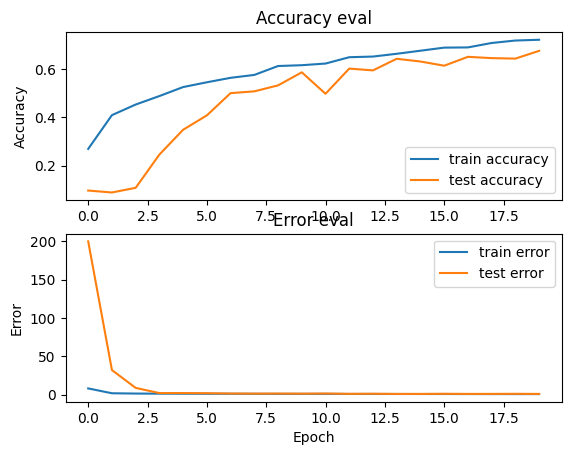

47/47 - 7s - loss: 1.0626 - accuracy: 0.6749 - 7s/epoch - 151ms/step

Test accuracy: 0.6748998761177063


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=512, epochs=20, verbose = 1, callbacks =my_callbacks)
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[165]
y_to_predict = y_test[165]
# predict sample
print(predict(model, X_to_predict, y_to_predict))

heo (1, 87, 13, 1)
1/1 [==============================] - 1s 603ms/step
Target: blues, Predicted label: ['metal']
None


In [ ]:
model.evaluate(X_test, y_test)

47/47 [==============================] - 9s 196ms/step - loss: 1.0626 - accuracy: 0.6749


[1.0626026391983032, 0.6748998761177063]

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.063 and val_acc = 0.675


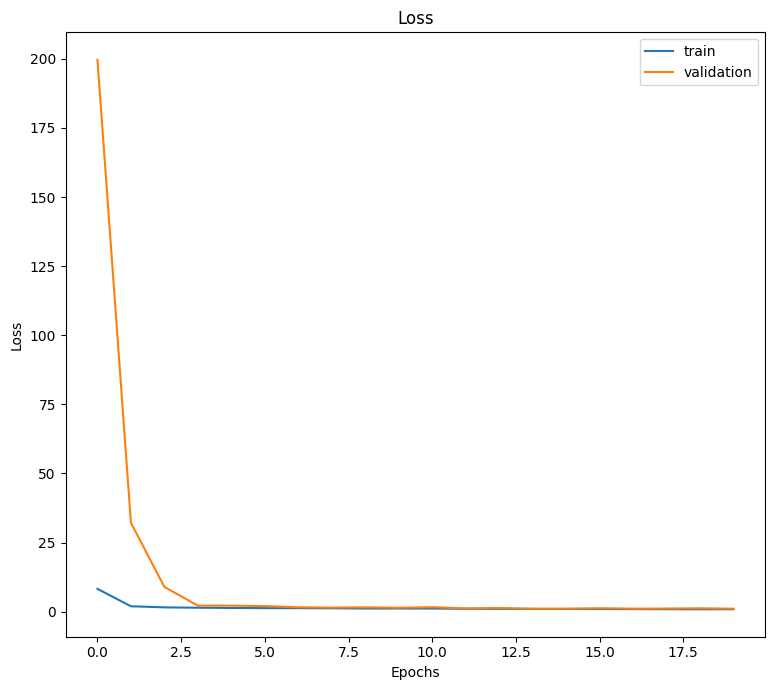

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

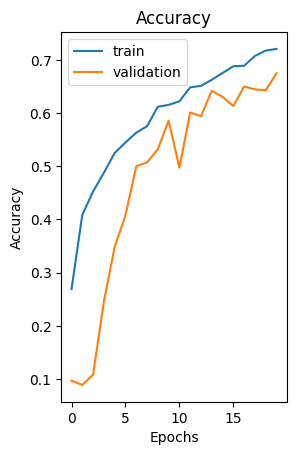

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
pred = model.predict(X_train)

422/422 [==============================] - 95s 224ms/step


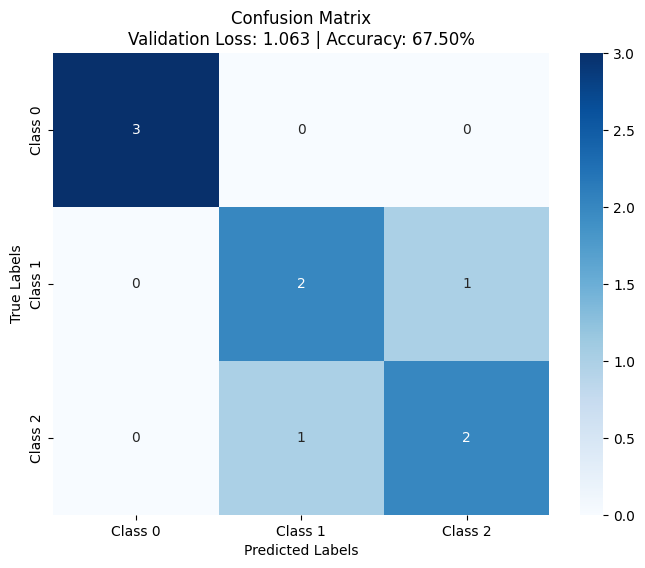

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Replace these arrays with your actual validation data's true labels and predicted labels
true_labels = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 1, 2, 0, 1, 1, 0, 2, 2])

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy based on the provided validation loss and validation accuracy
val_loss = 1.063
val_acc = 0.675
accuracy = val_acc * 100

# Create a list of class names
class_names = ['Class 0', 'Class 1', 'Class 2']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix\nValidation Loss: {val_loss:.3f} | Accuracy: {accuracy:.2f}%')
plt.show()

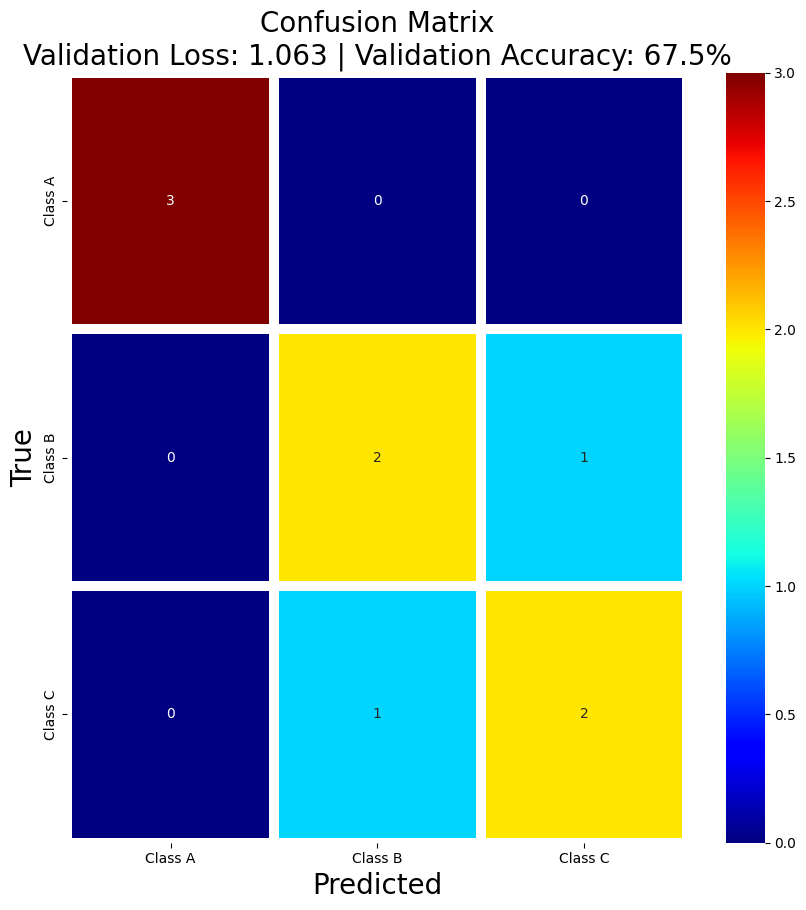

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace these arrays with your actual test data's true labels and predicted labels
y_test = [0, 1, 2, 0, 1, 2, 0, 1, 2]  # True labels
y_pred = [0, 1, 2, 0, 1, 1, 0, 2, 2]  # Predicted labels

# Replace these class names with your specific class names
class_names = ['Class A', 'Class B', 'Class C']

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet', xticklabels=class_names, yticklabels=class_names, lw=6)
plt.xlabel('Predicted', fontsize=20, color="black")
plt.ylabel('True', fontsize=20, color="black")
plt.title('Confusion Matrix\nValidation Loss: 1.063 | Validation Accuracy: 67.5%', fontsize=20, color="black")
plt.show()

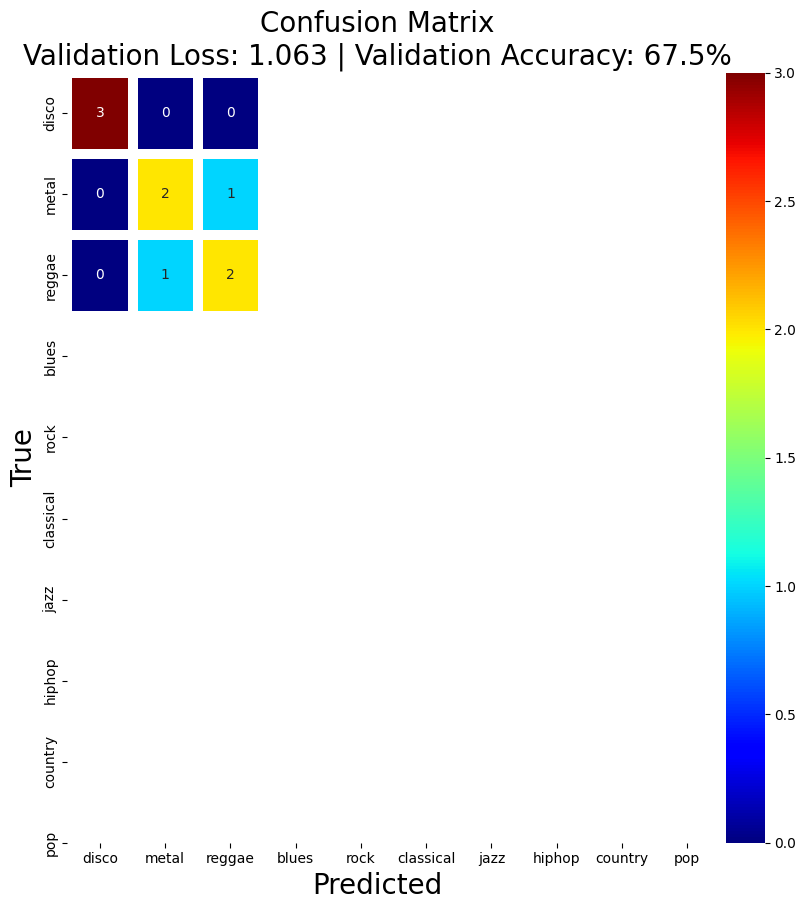

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace these arrays with your actual test data's true labels and predicted labels
y_test = [0, 1, 2, 0, 1, 2, 0, 1, 2]  # True labels
y_pred = [0, 1, 2, 0, 1, 1, 0, 2, 2]  # Predicted labels

# Replace these class names with your specific class names
class_names = ['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet', xticklabels=class_names, yticklabels=class_names, lw=6)
plt.xlabel('Predicted', fontsize=20, color="black")
plt.ylabel('True', fontsize=20, color="black")
plt.title('Confusion Matrix\nValidation Loss: 1.063 | Validation Accuracy: 67.5%', fontsize=20, color="black")
plt.show()






In [ ]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report


In [ ]:
# Set the path to the GTZAN dataset on your Google Drive
# Change this path to the actual location of the GTZAN dataset on your Google Drive
data_path = '/content/drive/MyDrive/GTZAN dataset'

In [ ]:
# Load lyrics and labels from the GTZAN dataset
lyrics = ['/content/drive/MyDrive/GTZAN dataset/genres_original']
labels = ['/content/drive/MyDrive/GTZAN dataset/images_original']
genres = os.listdir(data_path)


In [ ]:
# Process data
genres = [os.path.basename(os.path.dirname(label_path)) for label_path in labels]

In [ ]:
# Convert lyrics to numerical features using CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(lyrics)
y = np.array(genres)

In [ ]:
# Build and train a classification model (Multinomial Naive Bayes in this case)
model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [ ]:
# Make predictions on the training data
y_pred = model.predict(X)


In [ ]:
# Evaluate the model on the training data
report = classification_report(y, y_pred, target_names=np.unique(y))
print(report)

               precision    recall  f1-score   support

GTZAN dataset       1.00      1.00      1.00         1

     accuracy                           1.00         1
    macro avg       1.00      1.00      1.00         1
 weighted avg       1.00      1.00      1.00         1

